In [9]:
import numpy as np
import os
import torch

root = '/vulcanscratch/mgwillia/unsupervised-classification/imagenet-'
btwins_neighbors = np.load(root + 'btwins/pretext/topk-neighbors.npy')[:,1:]
dc_neighbors = np.load(root + 'dc/pretext/topk-neighbors.npy')[:,1:]
moco_neighbors = np.load(root + 'moco/pretext/topk-neighbors.npy')[:,1:]
sclr_neighbors = np.load(root + 'sclr/pretext/topk-neighbors.npy')[:,1:]
simsiam_neighbors = np.load(root + 'simsiam/pretext/topk-neighbors.npy')[:,1:]
sup_neighbors = np.load(root + 'sup/pretext/topk-neighbors.npy')[:,1:]
swav_neighbors = np.load(root + 'swav/pretext/topk-neighbors.npy')[:,1:]

print(btwins_neighbors.shape)
print(moco_neighbors.shape)
print(sclr_neighbors.shape)
print(sup_neighbors.shape)
print(swav_neighbors.shape)

#method_names = ['btwins', 'dc', 'moco', 'simclr', 'simsiam', 'supervised', 'swav']
method_names = ['btwins', 'dcv2', 'moco', 'simsiam', 'supervised', 'swav']
#neighbors = [btwins_neighbors, dc_neighbors, moco_neighbors, sclr_neighbors, simsiam_neighbors, sup_neighbors, swav_neighbors]
neighbors = [btwins_neighbors, dc_neighbors, moco_neighbors, simsiam_neighbors, sup_neighbors, swav_neighbors]

print('class-agonstic NN similarity, using 50 NNs:')
sim_map = {}
num_images_to_sample = 10000 #TODO: change to 100k, eventually do all of them!
for i in range(len(neighbors)):
    neighbors_a = neighbors[i]
    for j in range(i + 1, len(neighbors)):
        print(method_names[i], method_names[j])
        neighbors_b = neighbors[j]
        num_common_neighbors = 0
        indices_to_sample = np.random.choice(range(neighbors_a.shape[0]), size=num_images_to_sample, replace=False).tolist()
        for k in indices_to_sample:
            num_common_neighbors += np.intersect1d(neighbors_a[k], neighbors_b[k]).shape[0]
        sim = num_common_neighbors / (num_images_to_sample * neighbors_a.shape[1])
        print(sim)
        if method_names[i] not in sim_map:
            sim_map[method_names[i]] = {}
        if method_names[j] not in sim_map:
            sim_map[method_names[j]] = {}
        sim_map[method_names[i]][method_names[j]] = sim
        sim_map[method_names[j]][method_names[i]] = sim
        
print(sim_map)

(1331167, 50)
(1331167, 50)
(1331167, 50)
(1331167, 50)
(1331167, 50)
class-agonstic NN similarity, using 50 NNs:
btwins dcv2
0.425398
btwins moco
0.451098
btwins simsiam
0.490242
btwins supervised
0.247334
btwins swav
0.392968
dcv2 moco
0.38932
dcv2 simsiam
0.390752
dcv2 supervised
0.267882
dcv2 swav
0.539134
moco simsiam
0.437448
moco supervised
0.23284
moco swav
0.371968
simsiam supervised
0.19969
simsiam swav
0.379832
supervised swav
0.251978
{'btwins': {'dcv2': 0.425398, 'moco': 0.451098, 'simsiam': 0.490242, 'supervised': 0.247334, 'swav': 0.392968}, 'dcv2': {'btwins': 0.425398, 'moco': 0.38932, 'simsiam': 0.390752, 'supervised': 0.267882, 'swav': 0.539134}, 'moco': {'btwins': 0.451098, 'dcv2': 0.38932, 'simsiam': 0.437448, 'supervised': 0.23284, 'swav': 0.371968}, 'simsiam': {'btwins': 0.490242, 'dcv2': 0.390752, 'moco': 0.437448, 'supervised': 0.19969, 'swav': 0.379832}, 'supervised': {'btwins': 0.247334, 'dcv2': 0.267882, 'moco': 0.23284, 'simsiam': 0.19969, 'swav': 0.251978},

In [10]:
#method_names = ['btwins_r50_1000', 'dcv2_r50_800', 'moco_r50_800', 'simclr_r50_200', 'simsiam_r50_100', 'supervised_r50', 'swav_r50_800']
method_names = ['btwins_r50_1000', 'dcv2_r50_800', 'moco_r50_800', 'simsiam_r50_100', 'supervised_r50', 'swav_r50_800']
vissl_dir = '/vulcanscratch/mgwillia/vissl/predictions/'

predictions = {}
for method_name in method_names:
    if method_name not in results:
        results[method_name.split('_')[0]] = {}

    val_predictions = torch.load(os.path.join(vissl_dir, '_'.join([method_name, dataset, 'predictions']) + '.pth.tar'))['val_predictions']
    val_targets = torch.load(os.path.join(vissl_dir, '_'.join([method_name, dataset, 'targets']) + '.pth.tar'))['val_targets'].numpy()

    predictions[method_name.split('_')[0]] = val_predictions['res5'].numpy()

#dataset = 'imagenet'
dataset = 'cub'
overlap_map = {}
for i in range(len(method_names)):
    method_i = method_names[i].split('_')[0]
    for j in range(i + 1, len(method_names)):
        method_j = method_names[j].split('_')[0]
        if method_i not in overlap_map:
            overlap_map[method_i] = {}
        if method_j not in overlap_map:
            overlap_map[method_j] = {}
        overlap = np.where(predictions[method_i] == predictions[method_j], 1, 0).mean()
        overlap_map[method_i][method_j] = overlap
        overlap_map[method_j][method_i] = overlap
        
print(overlap_map)

{'btwins': {'dcv2': 0.691404901622368, 'moco': 0.6301346220227821, 'simsiam': 0.6423886779426994, 'supervised': 0.617880566102865, 'swav': 0.6727649292371418}, 'dcv2': {'btwins': 0.691404901622368, 'moco': 0.59285467725233, 'simsiam': 0.6070072488781498, 'supervised': 0.659302726958923, 'swav': 0.7209181912323093}, 'moco': {'btwins': 0.6301346220227821, 'dcv2': 0.59285467725233, 'simsiam': 0.637901277183293, 'supervised': 0.5188125647221263, 'swav': 0.5909561615464274}, 'simsiam': {'btwins': 0.6423886779426994, 'dcv2': 0.6070072488781498, 'moco': 0.637901277183293, 'supervised': 0.5281325509147394, 'swav': 0.6045909561615465}, 'supervised': {'btwins': 0.617880566102865, 'dcv2': 0.659302726958923, 'moco': 0.5188125647221263, 'simsiam': 0.5281325509147394, 'swav': 0.6332412840869865}, 'swav': {'btwins': 0.6727649292371418, 'dcv2': 0.7209181912323093, 'moco': 0.5909561615464274, 'simsiam': 0.6045909561615465, 'supervised': 0.6332412840869865}}


/tmp/ipykernel_63133/3888240215.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{abs(x):.1f}' for x in ax.get_yticks()])


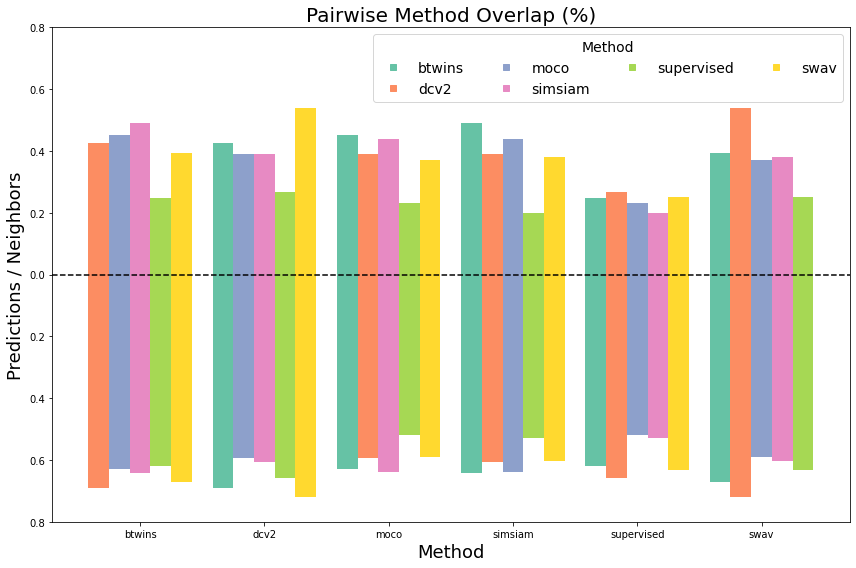

In [27]:
## TODO: consider adding linear eval overlaps as negative bars

import torch
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
cmap = plt.get_cmap('Set2')
colormap = np.array(list(cmap.colors))

#method_names = ['btwins', 'dcv2', 'moco', 'simclr', 'simsiam', 'supervised', 'swav']
method_names = ['btwins', 'dcv2', 'moco', 'simsiam', 'supervised', 'swav']

fig, ax = plt.subplots(1, 1)

x_s, heights, colors = [], [], []
counter = 1
for method_a in method_names:
    for i, method_b in enumerate(method_names): 
        if method_a != method_b:
            x_s.append(counter)
            heights.append(sim_map[method_a][method_b])
            colors.append(i)
        else:
            continue
            #x_s.append(counter)
            #heights.append(1.0)
            #colors.append(i)
        counter += 1
    counter += 1
ax.bar(x_s, heights, 1.0, color=colormap[colors])

x_s, heights, colors = [], [], []
counter = 1
for method_a in method_names:
    for i, method_b in enumerate(method_names):
        if method_a != method_b:
            x_s.append(counter)
            heights.append(-1 * overlap_map[method_a][method_b])
            colors.append(i)
        else:
            continue
            #x_s.append(counter)
            #heights.append(-1.0)
            #colors.append(i)
        counter += 1
    counter += 1
ax.bar(x_s, heights, 1.0, color=colormap[colors])

ax.axhline(y=0.0, color='black', linestyle='--')
ax.set_ylim(-0.8, 0.8)

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colormap[i]) for i in range(7)]
ax.legend(handles,
          method_names,
          title='Method',
          title_fontsize=14,
          scatterpoints=1,
          ncol=4,
          fontsize=14)

middle = (len(method_names) - 1) // 2
offset = 0.5 + (len(method_names) - 1) / 2 - middle
ax.set_xticks(offset + np.array(list(range(middle, len(method_names) * len(method_names) + middle, len(method_names)))))
ax.set_xticklabels(method_names)
ax.set_yticklabels([f'{abs(x):.1f}' for x in ax.get_yticks()])
plt.title(f'Pairwise Method Overlap (%)', fontsize=20)
plt.xlabel('Method', fontsize=18)
plt.ylabel('Predictions / Neighbors', fontsize=18)

fig.tight_layout()
plt.savefig(f'nn_overlap', bbox_inches = 'tight',
    pad_inches = 0.1)